# Analysis of Crime Reports in the City and County of Denver

#### Chris Richards
#### Practicum 2, Summer 2020
#### Regis University

### GridSearchCV with XGBoost Classification

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import graphviz

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

In [4]:
dates = [7, 8, 9] # date fields to read in as date objects, not strings
df_all = pd.read_csv(r"E:\Regis\Practicum_2\df_cleaned.csv", parse_dates=dates)

# Randomly sample 1% of the data (for faster processing during development. Comment out for finished model)
df = df_all.sample(frac=0.01)

# Get the whole data set
#df = df_all.copy(deep=True)

In [5]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 285007 to 317241
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              3712 non-null   int64         
 1   incident_id             3712 non-null   float64       
 2   offense_id              3712 non-null   int64         
 3   offense_code            3712 non-null   int64         
 4   offense_code_extension  3712 non-null   int64         
 5   offense_type_id         3712 non-null   object        
 6   offense_category_id     3712 non-null   object        
 7   first_occurrence_date   3712 non-null   datetime64[ns]
 8   last_occurrence_date    1597 non-null   datetime64[ns]
 9   reported_date           3712 non-null   datetime64[ns]
 10  incident_address        3403 non-null   object        
 11  geo_x                   3670 non-null   float64       
 12  geo_y                   3670 non-null   f

In [6]:
df2 = df.drop(columns=['Unnamed: 0', 
                       'incident_id', 
                       'offense_id', 'offense_code', 
                       'offense_code_extension',
                       'first_occurrence_date', 
                       'last_occurrence_date',
                       'reported_date', 
                       'offense_type_id', 
                       'incident_address', 
                       'geo_x', 
                       'geo_y'])
df2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 285007 to 317241
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   offense_category_id  3712 non-null   object 
 1   geo_lon              3712 non-null   float64
 2   geo_lat              3712 non-null   float64
 3   district_id          3712 non-null   int64  
 4   precinct_id          3712 non-null   int64  
 5   neighborhood         3712 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 203.0+ KB


In [7]:
rawX = df2.loc[:, df2.columns != 'offense_category_id'] # select all columns except for offense category
rawy = df2['offense_category_id']

In [8]:
X = pd.get_dummies(rawX)
#y = pd.get_dummies(rawy)
y = rawy

In [9]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=70)

In [10]:
ycount = y_test.count()
print(f'Number of rows in test set: {ycount}')

Number of rows in test set: 1114


#### GridSearchCV
   
Create XGBoost model

In [11]:
xg_model = xgb.XGBClassifier()

Create list of parameters

In [12]:
candidate_parameters = {
    'objective': ['multi:softmax'],
    'num_class': [15],
    'seed': [1970],
    'colsample_bytree': [0.1, 0.5, 0.75], 
    'learning_rate': [0.1, 0.5, 0.75], 
    'max_depth': [3, 5, 8, 15],
    'alpha': [1, 5, 10],
    'gamma': [1, 5, 10],
    'lambda': [1, 5, 10],
    'n_estimators': [5, 20, 50], 
    'min_child_weight': [0, 1, 2, 3],
    'tree_method': ['gpu_hist'],
    'early_stopping_rounds': [10]
}

Create GridSearchCV object

In [13]:
gs = GridSearchCV(
    estimator=xg_model,
    cv=5,
    param_grid=candidate_parameters,
    n_jobs=-1
)

Fit gridsearch  
WARNING: This process takes many hours (~10hrs) to complete!

In [14]:
gs.fit(X_train, y_train)

C:\Users\cr117\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[17:06:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                         'colsample_bytree': [0.1, 0.5, 0.75],
                         'early_stopping_rounds': [10], 'gamma': [1, 5, 10],
                         'lambda': [1, 5, 10],
                         'learning_rate': [0.1, 0.5, 0.75],
                         'max_depth'

Get best parameters

In [15]:
gs_best_params = gs.best_params_
gs_best_params

{'alpha': 5,
 'colsample_bytree': 0.75,
 'early_stopping_rounds': 10,
 'gamma': 1,
 'lambda': 1,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 0,
 'n_estimators': 50,
 'num_class': 15,
 'objective': 'multi:softmax',
 'seed': 1970,
 'tree_method': 'gpu_hist'}

Get best score

In [16]:
score = (gs.best_score_)*100
f"Accuracy (R^2): {score:.2f}%"

'Accuracy (R^2): 26.94%'

Get best estimator

In [17]:
gs_best_estimator = gs.best_estimator_
gs_best_estimator

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=10, gamma=1, gpu_id=0,
              importance_type='gain', interaction_constraints='', lambda=1,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=50, n_jobs=0, num_class=15, num_parallel_tree=1,
              objective='multi:softprob', random_state=1970, reg_alpha=5,
              reg_lambda=1, scale_pos_weight=None, seed=1970, subsample=1,
              tree_method='gpu_hist', ...)

#### Get results
Store the results of the model fitting

In [18]:
gs_results = gs.cv_results_

In [19]:
gs_predicts = gs.predict(X_test)


#### XGBoost Best Model
  
Fit the model using best parameters

In [20]:
fit_gs = gs_best_estimator.fit(X_train,y_train)
gs_preds = fit_gs.predict(X_test)

[17:06:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [21]:
score = fit_gs.score(X_train, y_train)*100
f"Accuracy (R^2) Model 2 training: {score:.2f}%"

'Accuracy (R^2) Model 2 training: 33.29%'

### Save the model to a file

In [23]:
from sklearn.externals import joblib 

C:\Users\cr117\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [24]:
# Save the model as a pickle in a file 
joblib.dump(gs, 'prac_gscv_xgb_model2.pkl') 
  
# Load the model from the file 
gs_model_from_joblib = joblib.load('prac_gscv_xgb_model2.pkl')  
  
# Use the loaded model to make predictions 
gs_model_from_joblib.predict(X_test) 

array(['public-disorder', 'public-disorder', 'all-other-crimes', ...,
       'theft-from-motor-vehicle', 'all-other-crimes', 'larceny'],
      dtype=object)

### Save as json file

In [25]:
fit_gs.save_model('prac2_gscv_xgb_fit_model3.json')

#### Model 2: Plots
Plot the top 10 most important features in the model.

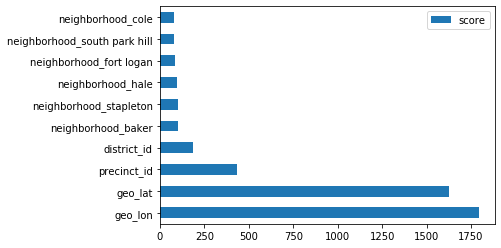

In [51]:
feature_important = fit_gs.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
x = data.head(10)
x.plot(kind='barh')

#### Visualize the decision tree

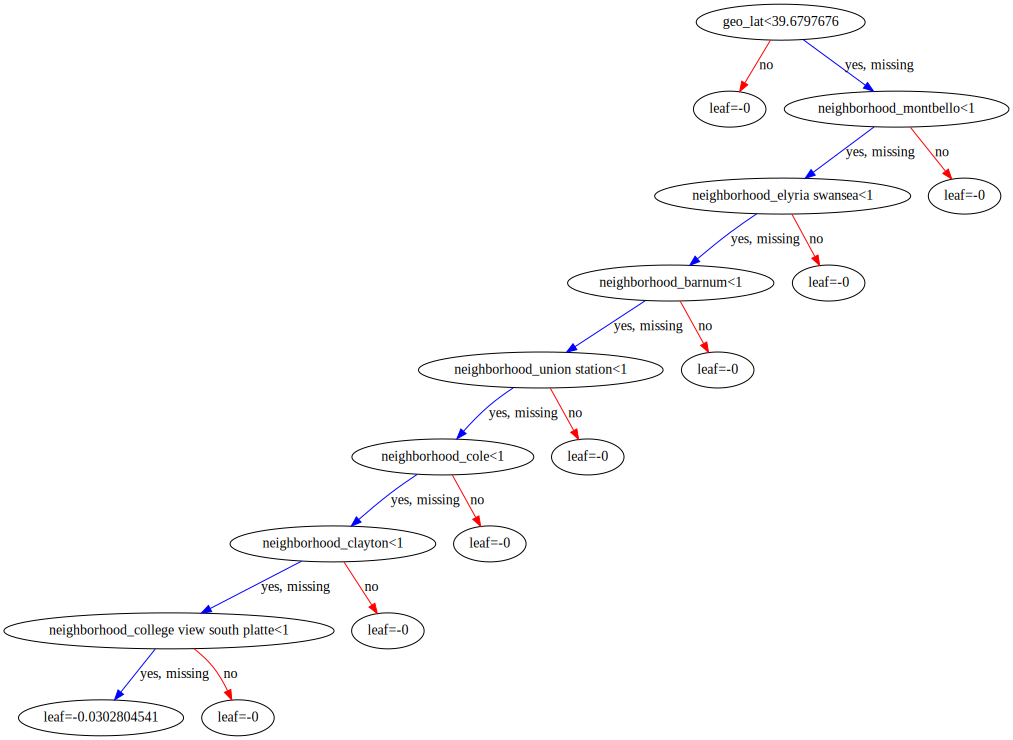

In [27]:
#xgb.to_graphviz(gs_best_estimator)

In [46]:
# use the model to make predictions with the test data

# how did our model perform?
print('Size of y_test: {}'.format(len(y_test)))

count_misclassified = (y_test != gs_preds).sum()

print('Misclassified samples: {}'.format(count_misclassified))

accuracy = (metrics.accuracy_score(y_test, gs_preds))*100

print('Accuracy: {:.2f}%'.format(accuracy))

Size of y_test: 1114
Misclassified samples: 802
Accuracy: 28.01%
